<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Step-1:-Try-to-identify-regular-buyers-with-help-of-control-group" data-toc-modified-id="Step-1:-Try-to-identify-regular-buyers-with-help-of-control-group-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step 1: Try to identify regular buyers with help of control group</a></span></li><li><span><a href="#Preprocess-data-for-modelling" data-toc-modified-id="Preprocess-data-for-modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocess data for modelling</a></span></li><li><span><a href="#Model-evaluation" data-toc-modified-id="Model-evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model evaluation</a></span><ul class="toc-item"><li><span><a href="#Tuning-with-Precision-Recall-Curve" data-toc-modified-id="Tuning-with-Precision-Recall-Curve-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tuning with Precision-Recall-Curve</a></span></li></ul></li><li><span><a href="#Apply-Strategy,-Evaluate-IRR-and-NIR" data-toc-modified-id="Apply-Strategy,-Evaluate-IRR-and-NIR-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Apply Strategy, Evaluate IRR and NIR</a></span></li></ul></div>

# Uplift Modelling Exercise: Starbucks



(Note: A good blogpost giving an oversight over general uplift strategies using the same data can be found [here](https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2)).

**Main learnings from this notebook**

- oversampling with categorical features only works with SMOTENC
- sampling does not work within sklearn pipelines, you must use imblearns own Pipline class
- you can pass feature labels into the pipeline, but the SMOTENC sampler needs the indices of the cat features

 
**Background Information**

The dataset in this exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

The main point of this implementation was to create a pipeline that oversamples the minority target class with SMOTENC (see [here](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html)) and selects an appropriate classifier. Without much further tuning the benchmark metrics could be matched / beaten.

**Optimization Strategy**

The task is to use the training data to understand what patterns in V1-V7 indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

- **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the promotion group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


- **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).


**Strategy Evaluation**

The strategy can be evaluated with the `test_results` function.  There are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  Comparing quadrant I to II then gives an idea of how well the promotion strategy will work in the future. 

In [41]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

from sklearn.model_selection import GridSearchCV, cross_validate, \
        StratifiedKFold, train_test_split
from sklearn.pipeline import FeatureUnion  # the actual pipe is imported from imblearn, see below
from sklearn.metrics import make_scorer, classification_report, \
        confusion_matrix, fbeta_score, precision_recall_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# pipeline caching
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.utils import Memory

# my custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning
import custom_transformers as transform

from imblearn.over_sampling import SMOTENC # can handle cat variables
from imblearn.pipeline import Pipeline  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color='rebeccapurple'

more infos on why `imblearn.pipeline` [here](https://stackoverflow.com/questions/49770851/customized-transformermixin-with-data-labels-in-sklearn/49771602#49771602)

In [7]:
# Load the data
train = pd.read_csv('data/training.csv')

In [3]:
train.sample(5)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
79764,119039,No,0,1,18.354225,1.432250,2,2,2,2
59555,88733,Yes,0,1,32.692856,0.393317,2,3,4,1
45378,67494,No,0,1,33.107859,0.826206,2,2,2,2
38262,56881,No,0,2,34.413043,1.172517,1,1,3,2
1018,1509,Yes,0,1,26.581578,-0.126150,1,1,2,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


## Prepare Data

General EDA is documented in notebook 1. The approach here is more specific.

In [4]:
# Make a copy of training set for EDA purpose
eda = train.copy()

In [15]:
# Separate treated group from control group
eda_no = eda.loc[eda['Promotion'] == 'No']
eda_yes = eda.loc[eda['Promotion'] == 'Yes']

print("Proportion of customers not treated with promo: {:.2f}%, (n={})".format(
        (len(eda_no) / len(eda) * 100), len(eda_no)))

Proportion of customers not treated with promo: 49.89%, (n=42170)


In [29]:
print("Proportion of purchases in control group: {:.2f}%, (n={})".format(
        round((eda_no['purchase'].value_counts()[1] / len(eda_no)*100), 4), 
        eda_no['purchase'].value_counts()[1]))
print("Proportion of purchases in control group: {:.2f}%, (n={})".format(
        round((eda_yes['purchase'].value_counts()[1] / len(eda_yes)*100), 4), 
        eda_yes['purchase'].value_counts()[1]))


Proportion of purchases in control group: 0.76%, (n=319)
Proportion of purchases in control group: 1.70%, (n=721)


## Step 1: Try to identify regular buyers with help of control group

In [33]:
# Define function to clean dataframes according to notebook 1

def clean_dataframe(df, treatment=None):
    if treatment is 'yes':
        df_clean = df.loc[df['Promotion'] == 'Yes']
    if treatment is 'no':
        df_clean = df.loc[df['Promotion'] == 'No']
    else:
        df_clean = df
    
    colsToCat = ["Promotion", "V1", "V4", "V5", "V6", "V7"]
    df_clean = cleaning.change_dtypes(df_clean, cols_to_category=colsToCat)
    df_clean.drop(['ID', 'Promotion'], axis=1, inplace=True)
    
    return df_clean

In [36]:
train_no = clean_dataframe(train, treatment='no')

# Check result
train_no.shape

(42170, 8)

In [37]:
# Define function to separate target variable from features

def create_Xy(df, target_col):
    """Seprate target variable from features."""

    y = df[target_col].copy()
    X = df.drop(target_col, axis=1)
    
    return X, y

In [38]:
# Call function an check results
X, y = create_Xy(train_no, 'purchase')
print(X.shape)
print(y.shape)

(42170, 7)
(42170,)


In [42]:
# Split train and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=666, stratify=y)

In [44]:
# Safety check distribution of target labels in y_train
print("PURCHASE in % of total: {:4.4f}".format(np.sum(y_train) / len(y_train)))

PURCHASE in % of total: 0.0076


In [45]:
def build_pipe(X_train, y_train, clf, sampler):
    """Build a pipeline for preprocessing (including oversampling)
    and classification.
    
    Arguments:
    ----------
    - X_train: training features (df or array
    - y_train: training labels (df or array)
    - clf: classifier (sk-learn model object)
    - sampler: sampler (imblearn sampling class)
        
    Returns:
    --------
    - full_pipe: pipeline object
    """
    
    # Create temporary folder to store pipeline transformers (cache)
    cachedir = mkdtemp()
    memory = Memory(location=cachedir, verbose=1)
    
    full_pipe = Pipeline([
    ('features', FeatureUnion([

        ('cat', Pipeline([
            ('cat_select', transform.TypeSelector('category')),
            ('ohe', OneHotEncoder(categories='auto')),
        ])),

#         ('num', Pipeline([
#             ('num_select', transform.TypeSelector(np.number)),
#             ('scaling', StandardScaler()),
#         ])),
    ])),
        ('sample', sampler),
        ('clf', clf)],
        
    memory=memory)
    
    return full_pipe


In [46]:
# Call the function and build the pipeline

clf = LogisticRegression()
sampler = SMOTENC(categorical_features=[0,3,4,5,6], n_jobs=-1)

full_pipe = build_pipe(X, y, clf, sampler)

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Memory is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
def fit_pipe(X_train, y_train, pipe, scorer, cv=StratifiedKFold(3)):
    """Fit training data to a pipeline with GridSearchCV
    for best parameter tuning.
    
    Arguments:
    ----------
    - X_train: training features (df or array)
    - y_train: training labels (df or array)
    - pipe: pipeline (sk-learn pipeline object)
    - scorer: evaluation metric for validation
    - cv: type of CV, default is StratifiedKFold(3)
        
    RETURNS:
    - grid: grid search object
    - grid_results: dict with grid search results
    """
    parameters = {'clf' : (GradientBoostingClassifier(n_estimators=200))),
                          (GradientBoostingClassifier(n_estimators=200)),
                          (SGDClassifier(loss='hinge', class_weight='balanced')),
                          )}
    
    start = time.time()

    cv = GridSearchCV(pipe, param_grid=parameters, scoring=scorer, n_jobs= -1, 
                      cv=cv, error_score='raise', return_train_score=False, verbose=1)

    grid = cv.fit(X_train, y_train) 
    grid_results = grid.cv_results_

    return grid, grid_results

    # delete the temporary cache before exiting
    rmtree(cachedir)

    print('Duration: {} seconds'.format(time.time() - start))

In [29]:
# call the function

scorer = make_scorer(fbeta_score, beta=4)
cv = 3

grid, grid_results = fit_pipe(X, y, full_pipe, scorer, cv=cv)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.6min finished


________________________________________________________________________________
[Memory] Calling imblearn.pipeline._fit_transform_one...
_fit_transform_one(FeatureUnion(n_jobs=None,
             transformer_list=[('cat',
                                Pipeline(memory=None,
                                         steps=[('cat_select',
                                                 TypeSelector(dtype='category')),
                                                ('ohe',
                                                 OneHotEncoder(categorical_features=None,
                                                               categories='auto',
                                                               drop=None,
                                                               dtype=<class 'numpy.float64'>,
                                                               handle_unknown='error',
                                                               n_values=None,
                  

In [30]:
# Define function to create simplified dataframe with results

def print_grid_results(grid_results, estimator_names):
    """Create simplified DataFrame with grid search results. Best suited
    for comparision of different (baseline) models.
    
    Arguments:
    ----------
    - grid_results: dict with results of grid search
    - estimator_names: list of strings with estimator short names
            
    Returns:
    --------
    - results: DataFrame with key metrics (test scores, time) for grid search    
    """
    
    results = pd.DataFrame(grid_results)# .sort_values('mean_test_score', ascending=False)
    results['total_time'] = results['mean_score_time'] + results['mean_fit_time']
    results = results[['param_clf', 'mean_test_score', 'std_test_score', 
                       'total_time', 'mean_fit_time', 'mean_score_time']]
    results.index = estimator_names
    
    return results

In [31]:
# Call the function and display the results
results = print_grid_results(grid_results, estimator_names=['LogReg', 'GBC', 'SGD'])
results

,param_clf,mean_test_score,std_test_score,total_time,mean_fit_time,mean_score_time
LogReg,"LogisticRegression(C=1.0, class_weight='balanc...",0.188854,0.002312,120.760333,120.720716,0.039617
GBC,([DecisionTreeRegressor(criterion='friedman_ms...,0.194483,0.003937,85.495153,85.301824,0.193329
SGD,"SGDClassifier(alpha=0.0001, average=False, cla...",0.192120,0.003403,0.827629,0.784585,0.043044


In [32]:
# Define a function for plotting the main results of the model comparision

def plot_grid_results(results):
    """Plot copmarision of test scores and run times for cross validated
    models.
       
    Arguments:
    ----------
    - results: dataframe generated with 'compare_models' function.
    
    Returns:
    --------
    - none, plot with visual comparision of the results for grid search
    """
    
    data = results.sort_values(by='mean_test_score', ascending=False)
    plt.figure(figsize=(18,6));
    plt.subplot(1,2,1)
    # plot the mean test scores
    sns.barplot(x='mean_test_score', y=data.index, data=data, color="rebeccapurple")
    plt.xlabel(scorer);
    plt.subplot(1,2,2)
    # Plot the mean total time
    sns.set_color_codes("pastel")
    sns.barplot(x="total_time", y=data.index, data=data,
        label="Total", color="rebeccapurple")
    # Plot the mean fit time
    sns.set_color_codes("muted")
    sns.barplot(x='mean_fit_time', y=data.index, data=data,
        label="Fit", color="yellow")
    plt.xlabel("Time for fitting (yellow) and scoring (purple)");

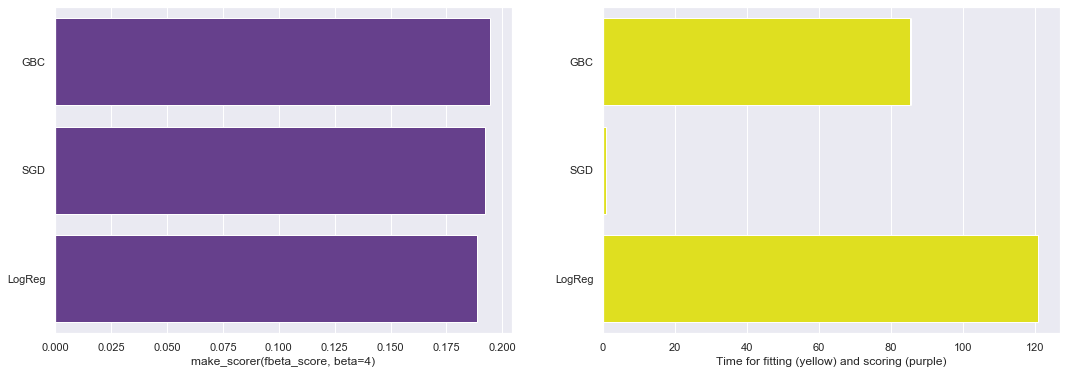

In [33]:
# Call the function and display the results
plot_grid_results(results)

In [34]:
# Get the best estimator
model = grid.best_estimator_
print(model)

Pipeline(memory=Memory(location=C:\Users\r2d4\AppData\Local\Temp\tmpmojlt9bn\joblib),
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_select',
                                                                  TypeSelector(dtype='category')),
                                                                 ('ohe',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                       

## Model evaluation

In [35]:
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72     83494
           1       0.02      0.65      0.04      1040

    accuracy                           0.57     84534
   macro avg       0.51      0.61      0.38     84534
weighted avg       0.98      0.57      0.71     84534



In [36]:
# Define a function to plot the confusion matric and some metrics

def plot_confusion_matrix(y_test, test_preds):
    """Plot confusion matrix and print detailed metrics for evaluated
    model."""

    conf_matrix = confusion_matrix(y_test, test_preds)
    tn, fp, fn, tp = conf_matrix.ravel()

    label_names = np.sort(y.unique())
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d',
                cbar=False, xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

    for value, name in {tp: "True positives",
                        fp: "False positives",
                        tn: "True negatives",
                        fn: "False negatives",
                        }.items():
        print("{}: {} ({:.2f}%)".format(name, value,
                                        value / conf_matrix.sum() * 100))
    print("\nProportion of misclassified instances in total:",
          round((fp+fn) / (tp+fp+tn+fn), 2))
    print("Typ I error (Number of items wrongly identified as " +
          "positive out of total true negatives):", round(fp/(tn+fp), 2))
    print("Type II error (Number of items wrongly identified as " +
          "negative out of total true positives):", round(fn/(tp+fn), 2))

True positives: 680 (0.80%)
False positives: 36245 (42.88%)
True negatives: 47249 (55.89%)
False negatives: 360 (0.43%)

Proportion of misclassified instances in total: 0.43
Typ I error (Number of items wrongly identified as positive out of total true negatives): 0.43
Type II error (Number of items wrongly identified as negative out of total true positives): 0.35


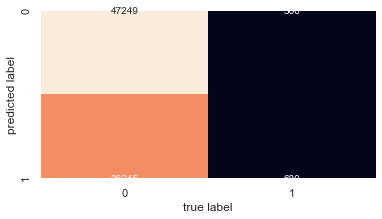

In [37]:
plot_confusion_matrix(y, y_pred)

In [38]:
print(confusion_matrix(y, y_pred))

[[47249 36245]
 [  360   680]]


### Tuning with Precision-Recall-Curve

One of the best methods for tuning a model for a _business need_ is through the precision recall curve. This shows the precision-recall tradeoff for different thresholds. Depending on the business requirement, we can change the threshold for classifying a positive example to alter the balance of true positives, false positives, false negatives, and true negatives. There will always be a tradeoff between precision and recall, but we can try to find the right balance by visually and quantitatively assessing the model. ([Source](https://github.com/Featuretools/predict-customer-churn/blob/master/churn/5.%20Modeling.ipynb))

- **precision**: true positives / (true positives + false positives) - how many of my model's identified positives are correct
- **recall (sensivity)**: true positives / (true positives + false negatives) - how many of the positives are correctly identified as positive

Examples:
- for a model where false positives acceptable, false negatives not acceptable (medical model): high recall
- for a model where false positives not acceptable, false negatives acceptable (spam filter): high precision


As in our case we should should not send to FALSE NEGATIVES have false positives (buyer  false positives are quite costly we should aim for a high precision but this will be very tricky given the data an problem we have.

In [73]:
# Define a function for returning precision and recall

def return_precision_recall(y_test, probs, threshold_recall=None, figsize=(12,6)):
    """Plot a precision recall curve for predictions. 
        
    Arguments:
    ----------
    - y_test: 1D-array, actual labels of test set
    - probs: 2D-array, probabilities for negative and positive outcome
        for predicted labels
    - threshold_recall: float, proportion of actual positive class to
        be identified by the model (default=None)
    - figsize: tuple, size of the plot (default=(12,6))

    Returns:
    --------
    - prec_recall_df: dataframe, with precicion and recall for different 
        thresholds
    - [None, plot of precision-recall curve with fancy annotation for
        recall threshold if selected]
    
    
    Heavily inspired by: 
    https://github.com/Featuretools/predict-customer-churn/blob/master/churn/5.%20Modeling.ipynb
    """

    precision, recall, threshold = precision_recall_curve(y_test, 
                                                          probs[:,1])
    
    # Plot precision-recall curve
    plt.figure(figsize=figsize)
    plt.plot(recall, precision, color=color)
    plt.fill_between(recall, precision, alpha=0.2, color=color)
    plt.title("Precision-Recall Curve", size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xticks(size=12)
    plt.yticks(size=12)

    # Add annotation for recall-threshold
    if threshold_recall:
        p = precision[np.where(threshold == threshold_recall)[0]]
        r = recall[np.where(threshold == threshold_recall)[0]]
        plt.scatter(r, p, marker='*', s=600, c='r')
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')
        plt.text(r - 0.1, p + 0.15,
                 s=f'Threshold: {round(threshold_recall, 2)}', 
                 size=20, 
                 fontdict={'weight': 1000})
        plt.text(r - 0.2, p + 0.075,
                 s=f'Precision: {round(100 * p[0], 2)}% Recall: \
                                {round(100 * r[0], 2)}%',
                 size=20,
                 fontdict={'weight': 1000})

    prec_recall_df = pd.DataFrame({'precision': precision[:-1], 
                                   'recall': recall[:-1],
                                   'threshold': threshold})
    return prec_recall_df

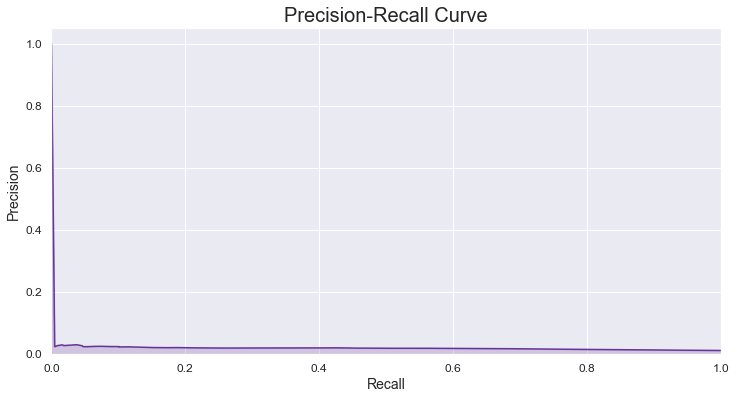

In [75]:
probs = model.predict_proba(X)
prec_recall_df = return_precision_recall(y, probs, threshold_recall=None)

We can query the precision-recall-dataframe to find the threshold required for a given precision or recall. For example, to find the threshold for a precision of 25%, we use the following code:

## Apply Strategy, Evaluate IRR and NIR

In [39]:
# Define a function for returning the predictions

def apply_strategy(X):
    '''
    Arguments:
    ----------
    - X: Training data (Dataframe) with columns V1 - V7 only

    Returns:
    --------
    - promotion: np.array with the values 'Yes' or 'No' related 
        to whether or not an individual should recieve a promotion
    '''
    
    y_pred = list(model.predict(X))
    promotion = ['Yes' if x == 1 else 'No' for x in y_pred]
    promotion = np.array(promotion)
    
    return promotion

In [40]:
# Call function and check results
promotion_strategy = apply_strategy(X)
print(promotion_strategy)

['No' 'Yes' 'No' ... 'Yes' 'Yes' 'Yes']


In [41]:
# Define evaluation functions to predict on test set and display performance in comparision to benchmark

def calc_score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    
    return (irr, nir)

def test_results(promotion_strategy):
    test_data = pd.read_csv('data/Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    df = cleaning.change_dtypes(df, cols_to_category=['V1', 'V4', 'V5', 'V6', 'V7'])
    promos = apply_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = calc_score(score_df)
    
    print("Nice job!  See how well your strategy worked on our test data below!")
    print('\nYour irr with this strategy is {:0.4f}.'.format(irr))
    print('\nYour nir with this strategy is {:0.2f}.'.format(nir))
    print("\nWe came up with a model with an irr of {} and an nir of {} " \
    "on the test set.\n\n How did you do?".format(0.0188, 189.45))
    
    return irr, nir

In [42]:
# Call function and evaluate performance
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0181.

Your nir with this strategy is 260.60.

We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01805796415425048, 260.60000000000014)

---